Package importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Read a data

In [3]:
train_path=r"C:\Programs Practice\Python\Machine learning Tasks (codesoft)\genre_predictor\Genre Classification Dataset\train_data.txt"
train_data=pd.read_csv(train_path,sep=":::",names=["TITLE","GENRE","DESCRIPTION"],engine="python",encoding="utf-8")

In [4]:
train_data

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
train_data.describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [7]:
train_data.isnull().sum()

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [8]:
test_path=r"C:\Programs Practice\Python\Machine learning Tasks (codesoft)\genre_predictor\Genre Classification Dataset\test_data.txt"
test_data=pd.read_csv(test_path,sep=":::",names=["TITLE","DESCRIPTION"],engine="python")

In [9]:
test_data

,TITLE,DESCRIPTION
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...
54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   DESCRIPTION  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


EDA

C:\Users\acer\AppData\Local\Temp\ipykernel_19988\2757992099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data,y="GENRE",order=train_data["GENRE"].value_counts().index,palette="viridis")


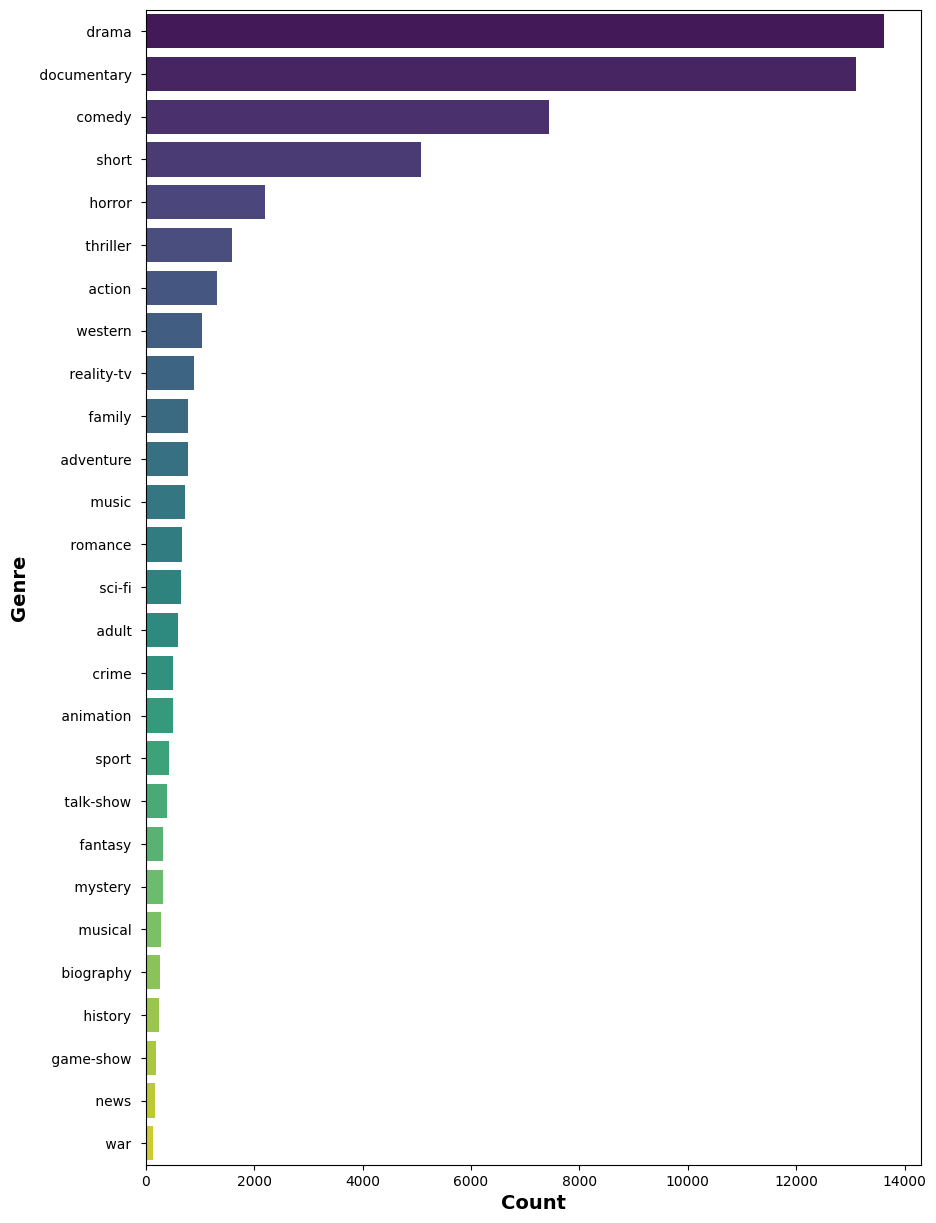

In [11]:
plt.figure(figsize=(10,15))
sns.countplot(data=train_data,y="GENRE",order=train_data["GENRE"].value_counts().index,palette="viridis")
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')
plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_19988\1541931954.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data,x="GENRE",order=train_data["GENRE"].value_counts().index,palette="YlGnBu")


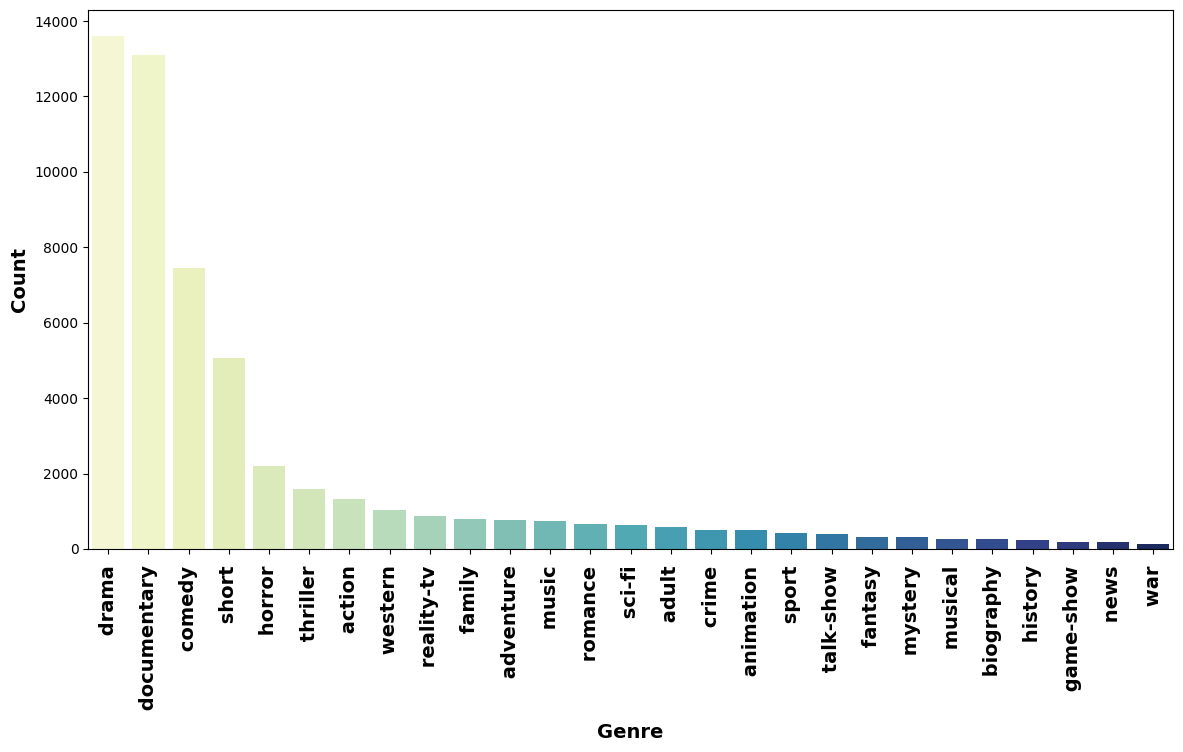

In [12]:
plt.figure(figsize=(14,7))
sns.countplot(data=train_data,x="GENRE",order=train_data["GENRE"].value_counts().index,palette="YlGnBu")
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

Data Preprocessing

In [13]:
stemmer = LancasterStemmer()

def cleaning_data(text):
 text = text.lower() # Convert to lower case
 text=re.sub(r'@\S+', '',text)
 text=re.sub(r'http\S+', '',text)
 text=re.sub(r'.pic\S+', '',text)
 text = re.sub(r'[^a-zA-Z+]', ' ', text) # Remove special characters and digits
 text = " ".join([word for word in text.split() if word not in string.punctuation])
 
 words=nltk.word_tokenize(text)
 stop_words = set(stopwords.words("english")) #Stopwords set
 # Use the predefined stop_words variable instead of redefining it inside the function
 text=" ".join([word for word in words if word not in stop_words and len(word)>2])
 return text


train_data["TextCleaning"]=train_data["DESCRIPTION"].apply(cleaning_data)
test_data["TextCleaning"]=test_data["DESCRIPTION"].apply(cleaning_data)

In [14]:
train_data

,TITLE,GENRE,DESCRIPTION,TextCleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...
...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,short lived nbc live sitcom centered bonino wo...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,next generation exploitation sisters kapa bay ...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",bestaan echt stand comedy growing facing fears...
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...


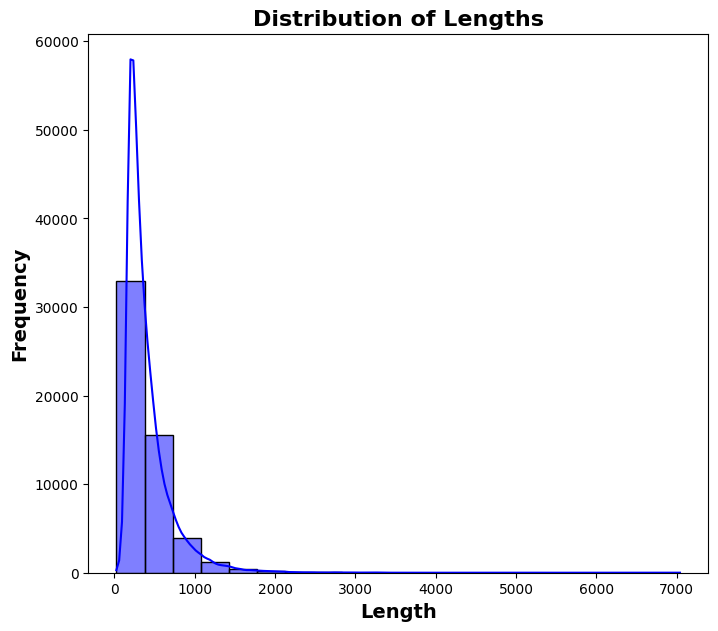

In [15]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['TextCleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

Using TF-IDF to vectorize the data

In [16]:
vectorize = TfidfVectorizer()

X_train = vectorize.fit_transform(train_data["TextCleaning"])

X_test = vectorize.transform(test_data["TextCleaning"])

In [17]:
X=X_train
y=train_data["GENRE"]

X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
model=SVC()
model.fit(X_train, Y_train)

SVC()

In [19]:
model.score(X_train,Y_train)

0.9034838947683936

In [20]:
y_pred=model.predict(X_test)
y_pred

array([' comedy ', ' drama ', ' comedy ', ..., ' drama ', ' short ',
       ' horror '], dtype=object)

In [21]:
accuracy=accuracy_score(Y_test,y_pred)
print("Validation Accuracy:",accuracy)

Validation Accuracy: 0.5675551046758277


In [22]:
print(classification_report(Y_test,y_pred))

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

      action        0.65      0.14      0.23       263
       adult        0.89      0.14      0.25       112
   adventure        0.50      0.09      0.15       139
   animation        1.00      0.01      0.02       104
   biography        0.00      0.00      0.00        61
      comedy        0.53      0.54      0.54      1443
       crime        0.00      0.00      0.00       107
 documentary        0.64      0.88      0.74      2659
       drama        0.49      0.84      0.62      2697
      family        0.73      0.05      0.10       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.35      0.52        40
     history        0.00      0.00      0.00        45
      horror        0.73      0.52      0.60       431
       music        0.77      0.25      0.38       144
     musical        0.00      0.00      0.00        50
     mystery        0.00      0.00      0.00        56
        n

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
